In [1]:
# Librerias y opciones globales
suppressMessages(library(Biostrings))
suppressMessages(library(ggplot2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(MASS))
options(repr.plot.width = 6, repr.plot.height = 4)
options(warn = -1)

In [2]:
# Función que determina la frecuencia de kmers para cada uno de los elementos de
# una colección de strings (i.e. archivo multifasta)
calc_freqs <- function(file_name, kmer) {
    # Carga archivo fasta
    fasta <- readDNAStringSet(file_name, "fasta")
    # Cuenta la frecuencia de kmers en la secuencia original y su reverso
    # complementaria para evitar sesgo de hebra
    count_plus <- oligonucleotideFrequency(fasta, kmer)
    count_minus <- oligonucleotideFrequency(reverseComplement(fasta), kmer)
    # Suma de ambos conteos y cálculo de frecuencias como dataframe.
    kmer_freqs <- as.data.frame(cbind(prop.table(count_plus + count_minus, 1)))
    # Obtengo nombre de las secuencias y los agrego al dataframe
    seq_names <- names(fasta)
    row.names(kmer_freqs) <- seq_names
    # Retorna el conteo de kmers para cada secuencia y el nombre de secuencia
    # asociado
    return(kmer_freqs)
}

In [19]:
kmer = 3
file_name = "/home/matias/vivax2/y486.53.norepe.fa"
z <- read.table(file = "~/vivax2/y486.index")
kmer_freqs <- calc_freqs(file_name, kmer)
# Mini-hack para quedarme con los nombres de las 32 vars diferentes
uniq3mers <- rownames(unique(t(kmer_freqs[4, ])))
kmer_freqs_uniq <- as.data.frame(kmer_freqs[, uniq3mers])
head(kmer_freqs_uniq, n=5)[,1:8]

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT
chr_1_1_1,0.01640656,0.01510604,0.01810724,0.01430572,0.01930772,0.01480592,0.01350540,0.01430572
chr_1_2_1,0.01860744,0.01830732,0.01720688,0.01380552,0.01800720,0.01260504,0.01900760,0.01380552
chr_1_8_1,0.02501000,0.01790716,0.01960784,0.01490596,0.02120848,0.01240496,0.01280512,0.01730692
chr_1_8_2,0.02480992,0.01680672,0.01930772,0.01700680,0.02280912,0.01160464,0.01470588,0.01630652
chr_1_9_1,0.02237500,0.01675000,0.01900000,0.01550000,0.02150000,0.01275000,0.01275000,0.01525000


In [4]:
# PCA con la función princomp, escalado y usando matriz de correlación
pca <- princomp(kmer_freqs_uniq, cor = TRUE)
# Creo un dataframe para los loadings (aporte de cada variable original)
x1 <- summary(pca)$loadings[, 1]
y1 <- summary(pca)$loadings[, 2]
loadings <- as.data.frame(cbind(x1, y1))
colnames(loadings) <- c("x1", "y1")

# Renombro los 2 codones stop que estan como su reverso complementario para
# identificarlos mejor
rownames(loadings)[rownames(loadings) == "TCA"] <- "TGA"
rownames(loadings)[rownames(loadings) == "CTA"] <- "TAG"

# Extraigo los 3 codones stop para facilitar identificación
loadings_stop <- loadings[c("TGA", "TAG", "TAA"), ]
loadings <- loadings[!rownames(loadings) %in% c("TGA", "TAG", "TAA"), ]

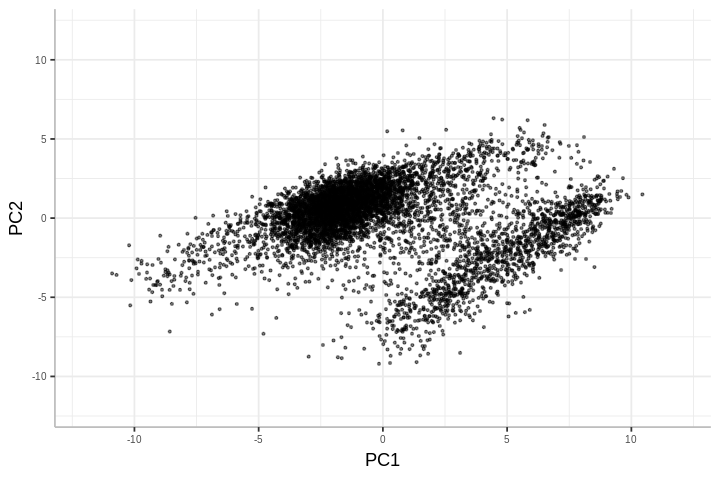

In [5]:
# Gráficas iniciales
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2])
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5) + 
    scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    axis.text.y = element_text(size = 6), axis.text.x = element_text(size = 6))

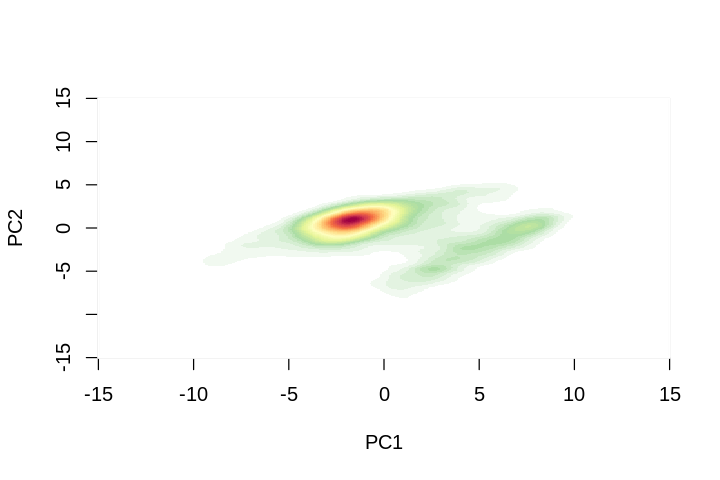

In [6]:
# Graficas de densidad
rf <- colorRampPalette(rev(c(brewer.pal(11, "Spectral")[1:8], "#FFFFFF")))
r <- rf(50)
k <- kde2d(pca_data$PC1, pca_data$PC2, n = 250)
image(k, col = r, xlim = c(-15, 15), ylim = c(-15, 15))
title(xlab = "PC1", ylab = "PC2")
box(which = "plot", lty = "solid", lwd = 2, col = "white")

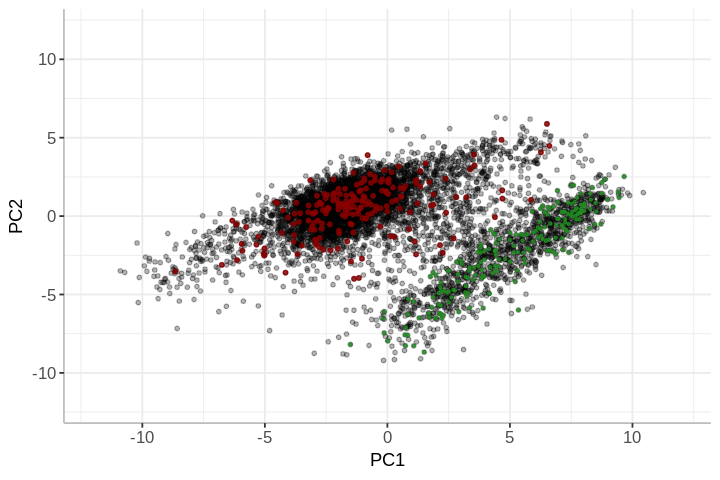

In [7]:
# Muestreo de regiones Core y Orfogenicas
anota1 <- pca_data[pca_data$PC2 > pca_data$PC1 * 1.1 - 5.5, ]
vsg1 <- pca_data[pca_data$PC2 < pca_data$PC1 * 1.1 - 5.5, ]
anota2 <- anota1[sample(nrow(anota1), 200), ]
vsg2 <- vsg1[sample(nrow(vsg1), 200), ]
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2])
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 1, alpha = 0.3) + 
    scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p1 <- p + geom_point(data = anota2, shape = 19, size = 1, alpha = 0.8, aes(PC1, PC2), 
    color = "darkred") + geom_point(data = vsg2, shape = 19, size = 0.6, alpha = 0.8, 
    aes(PC1, PC2), color = "forestgreen")
p1 + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 10), axis.text.y = element_text(size = 10), 
    axis.text.x = element_text(size = 10))

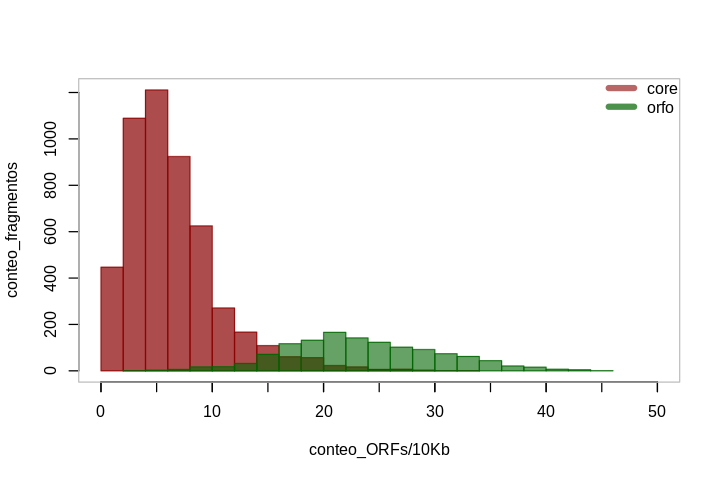

In [8]:
dat <- cbind(pca_data$PC1, pca_data$PC2, z$V2)
counts <- read.table("vivax2/y486.counts")
len <- read.table("vivax2/y486.len")
rownames(counts) <- counts$V1
rownames(len) <- len$V2

hist <- data.frame(rbind(cbind(counts[rownames(anota1), ]$V2 * (10000/len[rownames(anota1), 
    ]$V1), "core"), cbind(counts[rownames(vsg1), ]$V2 * (10000/len[rownames(vsg1), 
    ]$V1), "orfo")))
colnames(hist) <- c("core", "orfo")
par(cex = 0.8)
hist(counts[rownames(anota1), ]$V2 * (10000/len[rownames(anota1), ]$V1), breaks = 20, 
    col = alpha("darkred", 0.7), xlim = c(0, 50), main = "", xlab = "conteo_ORFs/10Kb", 
    ylab = "conteo_fragmentos", legend = c("core", "anota"), freq = T, border = alpha("darkred", 
        0.8))
hist(counts[rownames(vsg1), ]$V2 * (10000/len[rownames(vsg1), ]$V1), breaks = 20, 
    col = alpha("darkgreen", 0.6), add = TRUE, freq = T, border = alpha("darkgreen", 
        0.8))
legend("topright", c("core", "", "orfo"), col = c(alpha("darkred", 0.6), "white", 
    alpha("darkgreen", 0.7)), lwd = 5, bty = "n")
axis(1, at = seq(0, 50, by = 5), labels = NA)
box(col = "grey")

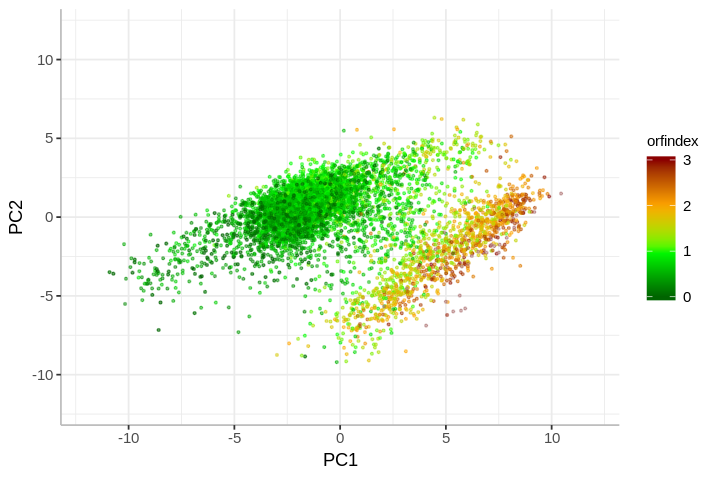

In [9]:
# Grafica de indice OI
oi <- read.table(file = "~/vivax2/y486.oi")
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2], zindex = oi$V2)
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5, 
    aes(colour = zindex)) + scale_colour_gradientn(colours = c("darkgreen", "green", 
    "orange", "darkred"), limits = c(0, 3), na.value = "lightgrey") + labs(colour = "orfindex", 
    x = "PC1", y = "PC2") + scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p1 <- p + geom_point(data = pca_data[pca_data$zindex > 3, ], mapping = aes(PC1, PC2), 
    shape = 19, size = 0.5, alpha = 0.2, colour = "darkred")
p2 <- p1 + geom_point(data = pca_data[pca_data$zindex < 0.2, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 0.5, alpha = 0.2, colour = "darkgreen")
p2 + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 9), legend.text = element_text(size = 9), 
    axis.text.y = element_text(size = 9), axis.text.x = element_text(size = 9))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


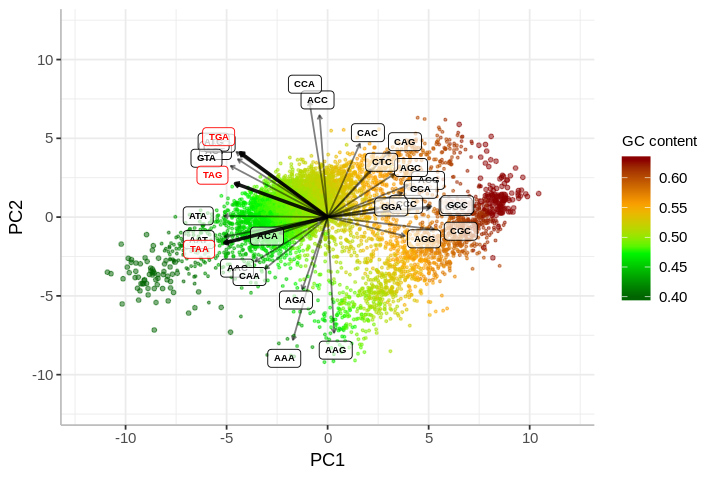

In [10]:
# Grafica GC con vectores
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2], zindex = z$V13/100)
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5, 
    aes(colour = zindex)) + scale_colour_gradientn(colours = c("darkgreen", "green", 
    "orange", "darkred"), limits = c(0.4, 0.63), na.value = "white") + labs(colour = "GC content", 
    x = "PC1", y = "PC2") + scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p1 <- p + geom_point(data = pca_data[pca_data$zindex > 0.63, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 1, alpha = 0.5, colour = "darkred")
p2 <- p1 + geom_point(data = pca_data[pca_data$zindex < 0.4, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 1, alpha = 0.5, colour = "darkgreen")
p3 <- p2 + geom_segment(aes(xend = x1 * 20 * -1, yend = y1 * 20, x = rep(0, 26), 
    y = rep(0, 26)), data = loadings, arrow = arrow(length = unit(0.1, "cm")), alpha = 0.5, 
    lwd = 0.5) + geom_label(alpha = 0.64, data = loadings, size = 2, fontface = "bold", 
    aes(x = x1 * 25 * -1, y = y1 * 23, label = rownames(loadings))) + geom_segment(aes(xend = x1 * 
    20 * -1, yend = y1 * 20, x = rep(0, 3), y = rep(0, 3)), data = loadings_stop, 
    arrow = arrow(length = unit(0.1, "cm")), alpha = 0.9, lwd = 1, color = "black") + 
    geom_label(alpha = 0.8, size = 2, data = loadings_stop, aes(x = x1 * 25 * -1, 
        y = y1 * 25, label = rownames(loadings_stop), fontface = "bold"), color = "red") + 
    scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))

p3 + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size =9), legend.text = element_text(size = 9), 
    axis.text.y = element_text(size = 9), axis.text.x = element_text(size = 9))

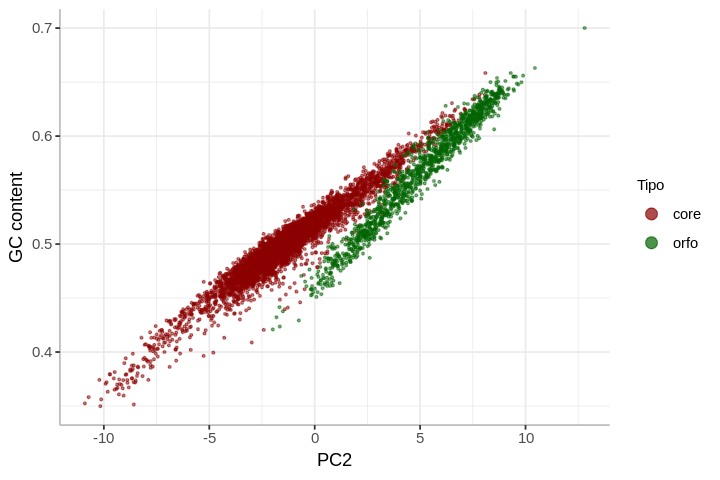

In [11]:
# Correlación entre PC1 y contenido GC
gc_data <- data.frame(PC1 = pca$scores[, 1] * -1, GC = z$V13/100)
an <- gc_data[rownames(anota1), ]
vn <- gc_data[rownames(vsg1), ]
vn$tipo = "orfo"
an$tipo = "core"
gc <- rbind(an, vn)

ggplot(gc, aes(PC1, GC, colour = tipo)) + geom_point(shape = 19, size = 0.5, alpha = 0.5) + 
    labs(colour = "Tipo", x = "PC2", y = "GC content") + scale_color_manual(values = c("darkred", 
    "darkgreen")) + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 9), axis.text.y = element_text(size = 9), 
    axis.text.x = element_text(size = 9)) + guides(colour = guide_legend(override.aes = list(size = 3, 
    alpha = 0.7)))

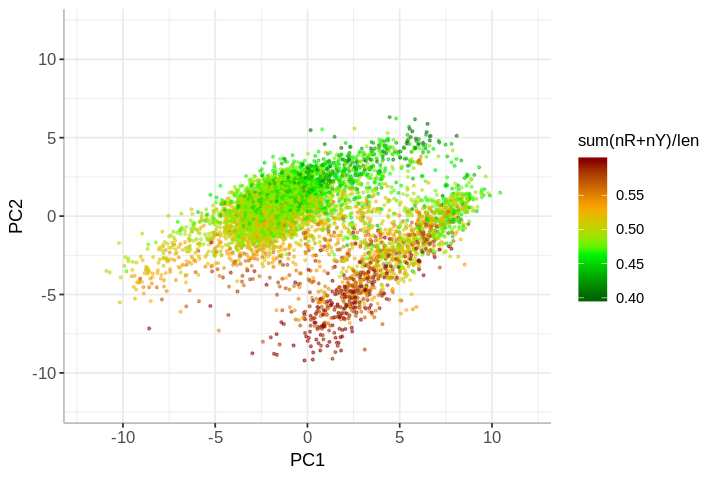

In [12]:
zz <- read.table(file = "~/vivax2/ry.3")
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2], zindex = zz$V4)
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5, 
    aes(colour = zindex)) + scale_colour_gradientn(colours = c("darkgreen", "green", 
    "orange", "darkred"), limits = c(0.4, 0.6), na.value = "white") + labs(colour = "sum(nR+nY)/len", 
    x = "PC1", y = "PC2") + scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p1 <- p + geom_point(data = pca_data[pca_data$zindex > 0.6, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 0.5, alpha = 0.5, colour = "darkred")
p2 <- p1 + geom_point(data = pca_data[pca_data$zindex < 0.4, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 0.5, alpha = 0.5, colour = "darkgreen")
p2 + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 10), axis.text.y = element_text(size = 10), 
    axis.text.x = element_text(size = 10))

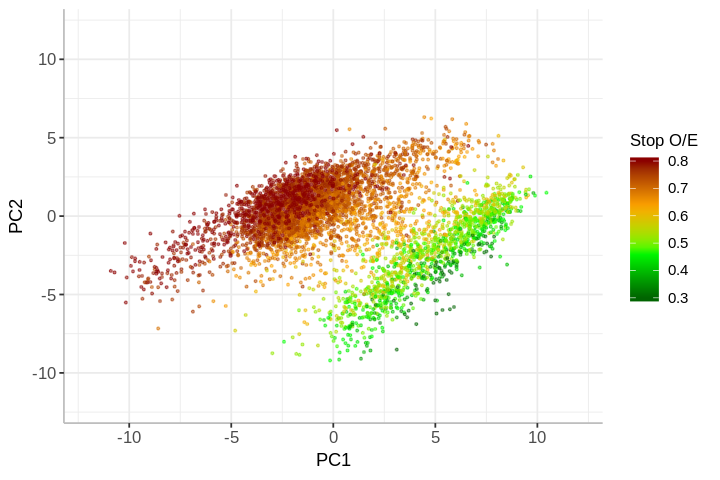

In [13]:
# Grafica de indice STOP O/E
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2], zindex = z$V2/z$V3)
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5, 
    aes(colour = zindex)) + scale_colour_gradientn(colours = c("darkgreen", "green", 
    "orange", "darkred"), limits = c(0.3, 0.8), na.value = "white") + labs(colour = "Stop O/E", 
    x = "PC1", y = "PC2") + scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p1 <- p + geom_point(data = pca_data[pca_data$zindex > 0.8, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 0.5, alpha = 0.5, colour = "darkred")
p2 <- p1 + geom_point(data = pca_data[pca_data$zindex < 0.3, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 0.5, alpha = 0.5, colour = "darkgreen")
p2 + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 10), legend.text = element_text(size = 9), 
    axis.text.y = element_text(size = 10), axis.text.x = element_text(size = 10))

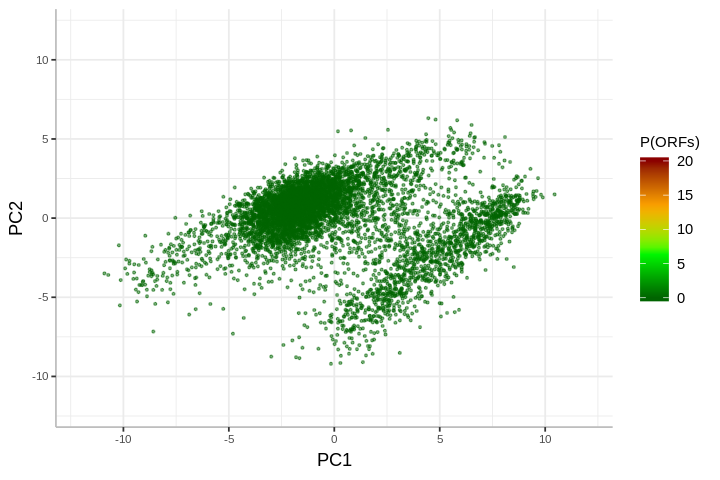

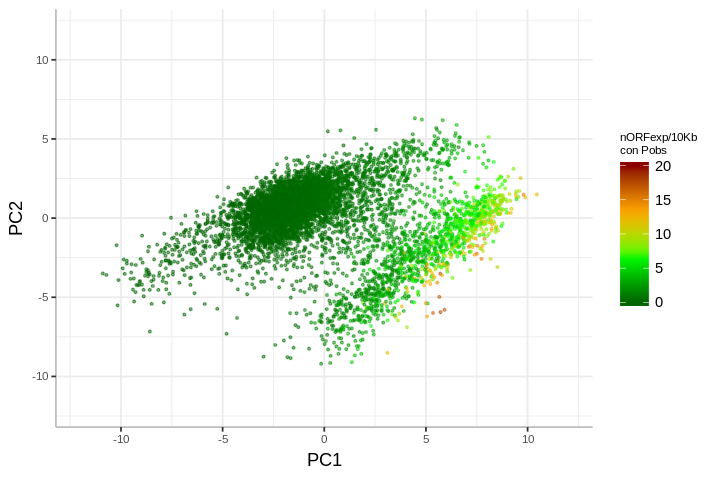

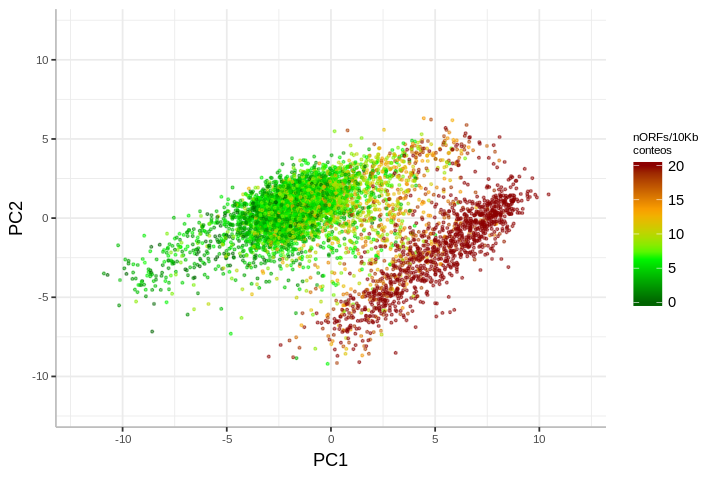

In [14]:
# Grafica nORFSexpPesp por 10Kb
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2], zindex = z$V12)
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5, 
    aes(colour = zindex)) + scale_colour_gradientn(colours = c("darkgreen", "green", 
    "orange", "darkred"), limits = c(0, 20), na.value = "white") + labs(colour = "P(ORFs)", 
    x = "PC1", y = "PC2") + scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 9), axis.text.y = element_text(size = 7), 
    axis.text.x = element_text(size = 7))

# Grafica nORFSexpPobs por 10Kb
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2], zindex = z$V7 * 
    (10000/z$V4))
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5, 
    aes(colour = zindex)) + scale_colour_gradientn(colours = c("darkgreen", "green", 
    "orange", "darkred"), limits = c(0, 20), na.value = "white") + labs(colour = "nORFexp/10Kb\ncon Pobs", 
    x = "PC1", y = "PC2") + scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p1 <- p + geom_point(data = pca_data[pca_data$zindex > 20, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 0.5, alpha = 0.5, colour = "darkred")

p1 + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 7), axis.text.y = element_text(size = 7), 
    axis.text.x = element_text(size = 7))

# Grafica nORFSreales por 10Kb
pca_data <- data.frame(PC1 = pca$scores[, 1] * -1, PC2 = pca$scores[, 2], zindex = z$V9 * 
    (10000/z$V4))
p <- ggplot(pca_data, aes(PC1, PC2)) + geom_point(shape = 19, size = 0.5, alpha = 0.5, 
    aes(colour = zindex)) + scale_colour_gradientn(colours = c("darkgreen", "green", 
    "orange", "darkred"), limits = c(0, 20), na.value = "white") + labs(colour = "nORFs/10Kb\nconteos", 
    x = "PC1", y = "PC2") + scale_y_continuous(limits = c(-12, 12)) + scale_x_continuous(limits = c(-12, 
    12))
p1 <- p + geom_point(data = pca_data[pca_data$zindex > 20, ], mapping = aes(PC1, 
    PC2), shape = 19, size = 0.5, alpha = 0.5, colour = "darkred")
p1 + theme_bw() + theme(panel.border = element_blank(), axis.line = element_line(colour = "grey"), 
    legend.title = element_text(size = 7), axis.text.y = element_text(size = 7), 
    axis.text.x = element_text(size = 7))